# TEST THIS WITH CELLCOMPOSITION ONLY

# Unsupervised Clustering 

### These notebook does 3 things:
1. Ingest embeddings, performs Leiden algorithm, train_classifier to obtain embeddings.
2. Take a sparse image, pass (cropper, backbone, classifier) get a mask.
3. Transfer the mask to the dataframe

### Common Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy


### Read prediction from file

In [4]:
global embeddings

ckpt_file = 'ckpt_TIS_748.pt'
prediction_file = 'prediction_dict_loader0_TIS_748.pt'

predictions = torch.load(prediction_file)

for k,v in predictions.items():
    if isinstance(v, torch.Tensor):
        print(k, type(v), v.shape)
    elif isinstance(v, list):
        print(k, type(v), len(v))
    else:
        print(k, type(v))

metadata <class 'list'> 7200
features_student_bbone <class 'torch.Tensor'> torch.Size([7200, 128])
features_teacher_bbone <class 'torch.Tensor'> torch.Size([7200, 128])
features_student_head <class 'torch.Tensor'> torch.Size([7200, 128])
features_teacher_head <class 'torch.Tensor'> torch.Size([7200, 128])
classify_tissue_label <class 'torch.Tensor'> torch.Size([7200])
classify_healthy_sick <class 'torch.Tensor'> torch.Size([7200])
regress_moran <class 'torch.Tensor'> torch.Size([7200])


### Unsupervised CLustering with Scanpy

In [5]:
import pandas as pd
import scanpy as sc
from tissue_purifier.misc_utils.misc import get_z_score

tmp_dict = {
    "conditions" : [0 if metadata.f_name.startswith("wt") else 1 for metadata in predictions['metadata']],
    "f_names" : [metadata.f_name for metadata in predictions['metadata']],
    "morans" : [metadata.moran for metadata in predictions['metadata']],
}

df = pd.DataFrame(tmp_dict)

features = get_z_score(predictions['features_teacher_head'].float(), dim=-2)

adata = sc.AnnData(X=features.cpu().numpy(), obs=df)
adata.obsm['X_raw'] = features.cpu().numpy()

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
sc.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca', method='umap', metric='euclidean')
# _ = plt.hist(adata.obsp['connectivities'].data, bins=50)

In [7]:
sc.tl.leiden(adata, resolution=0.3)
sc.tl.umap(adata)

... storing 'f_names' as categorical


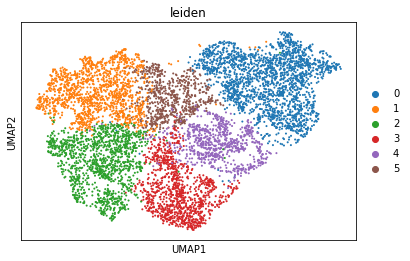

In [8]:
sc.pl.umap(adata, color=['leiden'], color_map=plt.cm.tab10)

### Unsupervised Clustering with Custon Functions

In [9]:
from tissue_purifier.misc_utils.misc import SmartPca, SmartUmap, SmartLeiden

In [10]:
smart_pca = SmartPca(preprocess_strategy='z_score')
embeddings_pca = smart_pca.fit_transform(predictions['features_teacher_head'], n_components=30)

In [11]:
smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw', n_components=2, min_dist=0.5)
embeddings_umap = smart_umap.fit_transform(embeddings_pca)
umap_graph = smart_umap.get_graph()

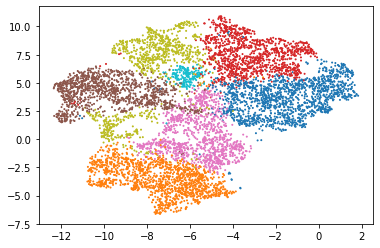

In [12]:
smart_leiden = SmartLeiden(graph=umap_graph)
cluster_labels = smart_leiden.cluster(resolution=0.3)
plt.scatter(-embeddings_umap[:, 0], embeddings_umap[:, 1], s=1, c=cluster_labels, cmap=plt.cm.tab10)

### Train a simple NearestNeighbour classifier to predict cluster labels

Text(0, 0.5, 'UMAP 2')

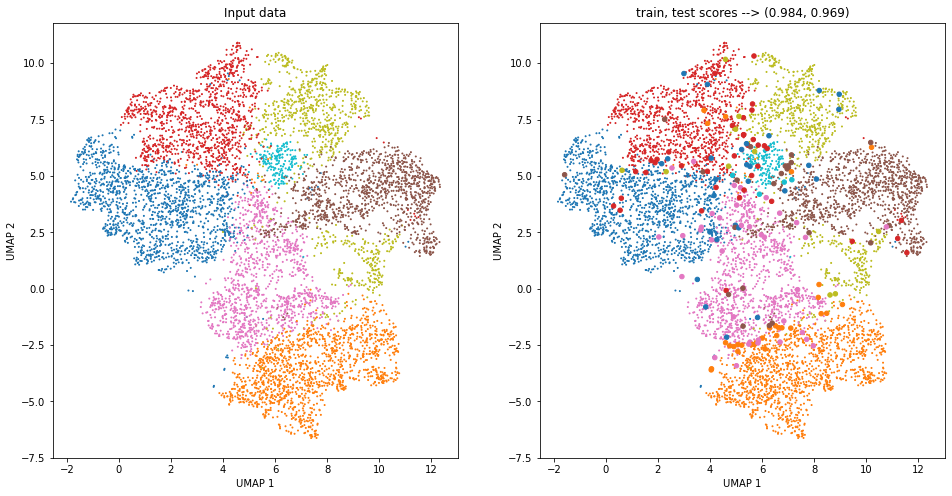

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X = embeddings_pca
y = cluster_labels.astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    stratify=y, 
    test_size=0.5,
    random_state=1,
    shuffle=True,
)

# Train the classifier and evaluate the performance
kn_classifier = KNeighborsClassifier(5)
kn_classifier.fit(X_train, y_train)
score_test = kn_classifier.score(X_test, y_test)
score_train = kn_classifier.score(X_train, y_train)
y_predicted = kn_classifier.predict(X)


# Make a figure
panel_size = 8
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(2*panel_size, panel_size))

axes[0].set_title("Input data")
axes[0].scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], s=1, c=y, cmap=plt.cm.tab10)   
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
    
mask = (y_predicted == y)
axes[1].set_title("train, test scores --> ({0:.3}, {1:.3})".format(score_train, score_test))
axes[1].scatter(embeddings_umap[mask, 0], embeddings_umap[mask, 1], s=1, c=y_predicted[mask], cmap=plt.cm.tab10)
axes[1].scatter(embeddings_umap[~mask, 0], embeddings_umap[~mask, 1], s=20, c=y_predicted[~mask], cmap=plt.cm.tab10)
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")

### Analyze entire images with tiling

In [37]:
from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM
from tissue_purifier.model_utils.dino import DinoModel

# Get the model from checkpoint
dino = DinoModel.load_from_checkpoint(ckpt_file)
config = dino._hparams
config["gpus"] = min(1, torch.cuda.device_count())

In [38]:
# Get the datamodule from config stored in the model
dm = SlideSeqTestisDM(**config)
dm_cropper = dm.cropper_reference
dm_transform = dm.trsfm_reference

# Extract the train_dataset made of full images
dm.prepare_data()
dm.setup()
train_loader = dm.train_dataloader()
train_dataset = train_loader.dataset

-----> running datamodule init
-----> running datamodule prepare_data
number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 2314, 2315])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 2319, 1670])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 2318, 2318])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 2311, 2318])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 2319, 2319])
number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 2287, 2288])
-----> running datamodule setup. stage ->None


In [39]:
vars(train_dataset)

{'labels_to_codes': {'sick': 0, 'wt': 1},
 'codes': [1, 1, 1, 0, 0, 0],
 'metadatas': [MetadataCropperDataset(f_name='wt1', loc_x=0.0, loc_y=0.0, moran=-99.9),
  MetadataCropperDataset(f_name='wt2', loc_x=0.0, loc_y=0.0, moran=-99.9),
  MetadataCropperDataset(f_name='wt3', loc_x=0.0, loc_y=0.0, moran=-99.9),
  MetadataCropperDataset(f_name='dis1', loc_x=0.0, loc_y=0.0, moran=-99.9),
  MetadataCropperDataset(f_name='dis2', loc_x=0.0, loc_y=0.0, moran=-99.9),
  MetadataCropperDataset(f_name='dis3', loc_x=0.0, loc_y=0.0, moran=-99.9)],
 'cropper': CropperSparseTensor(crop_size=336, strategy=random, stride=200, random_order=True,         n_element_min=250),
 'imgs': [<tissue_purifier.data_utils.sparse_image.SparseImage at 0x7faab9fcd8d0>,
  <tissue_purifier.data_utils.sparse_image.SparseImage at 0x7faab84e1fd0>]}

In [40]:
sp_images = train_dataset.imgs
labels = train_dataset.codes
metadatas = train_dataset.metadatas
list_f_names = [metadata.f_name for metadata in  metadatas]
cell_names = sp_images[0].code_to_cat.values()

# Make an analyzer (i.e. a very simple pipeline from features to property)
class Clusterer:
    def __init__(self, pca, classifier):
        self.pca = pca
        self.classifier = classifier
    def __call__(self, features: torch.Tensor):
        pca_features = self.pca.transform(data=features.cpu().numpy(), n_components=None)
        probs = self.classifier.predict_proba(pca_features)
        return probs

In [41]:
DEBUG THIS ONE. PLOT PCA, UMAP, ....

# For each image run the classify method  
for n, sp_img in enumerate(sp_images):
    print("working on", n)
    classifier_mask = sp_img.analyze_with_tiling(
        save_with_name="niche",
        feature_extractor=dino,
        analyzer=Clusterer(pca=smart_pca, classifier=kn_classifier),
        cropper_transform=(dm_cropper, dm_transform),
        batch_size=64,
        n_patches_max=10000,
        recompute=True,
    )
    

working on 0
working on 1
working on 2
working on 3
working on 4
working on 5


### Visualize the masks

In [126]:
from tissue_purifier.plot_utils.plot_images import show_raw_all_channels, show_raw_one_channel
from tissue_purifier.plot_utils.plot_misc import plot_counters
#from tissue_purifier.misc_utils.misc import channel_counter_in_window
pixel_size = 4
print(sp_images[0].image_properties['niche'].shape)

torch.Size([7, 2314, 2315])


In [154]:
for sp_img in sp_images:
    # Find the argmax of the niches
    value, index = torch.max(sp_img.image_properties['niche'], dim=-3)
    cluster_labels = torch.where(value > 0.25, index, -1 * torch.ones_like(index))
    sp_img.image_properties['niche_argmax'] = cluster_labels
    
    # Check the normalization to one
    normalization = torch.sum(sp_img.image_properties['niche'], dim=-3)
    sp_img.image_properties['niche_normalization'] = normalization

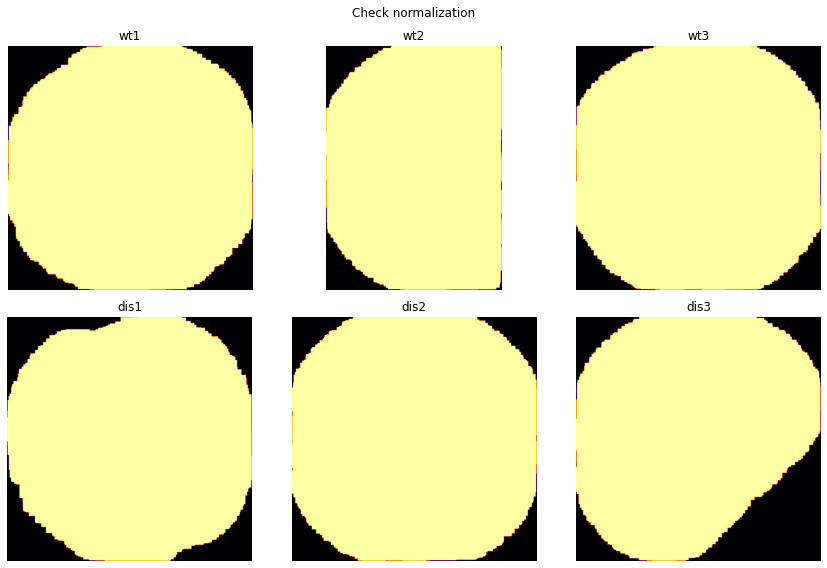

In [155]:
show_raw_one_channel([sp_img.image_properties['niche_normalization'] for sp_img in sp_images], n_col=3, labels=list_f_names, title="Check normalization")

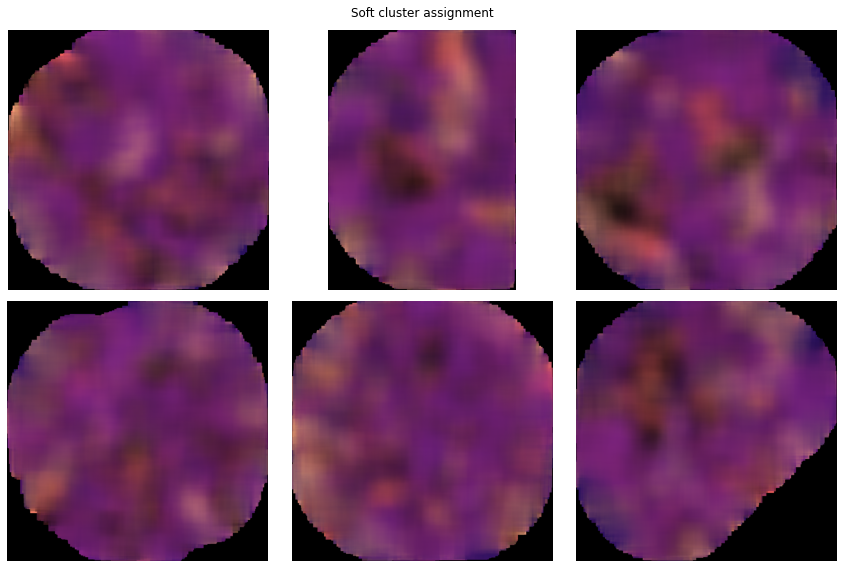

In [156]:
show_raw_all_channels([sp_img.image_properties['niche'] for sp_img in sp_images], cmap="magma", n_col=3, title="Soft cluster assignment")

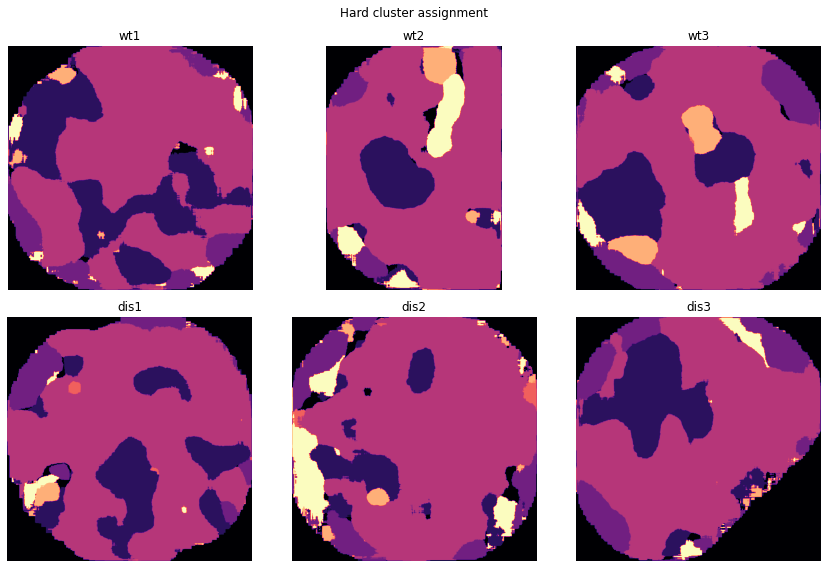

In [157]:
show_raw_one_channel([sp_img.image_properties['niche_argmax'].float() for sp_img in sp_images], cmap="magma", n_col=3, labels=list_f_names, title="Hard cluster assignment")

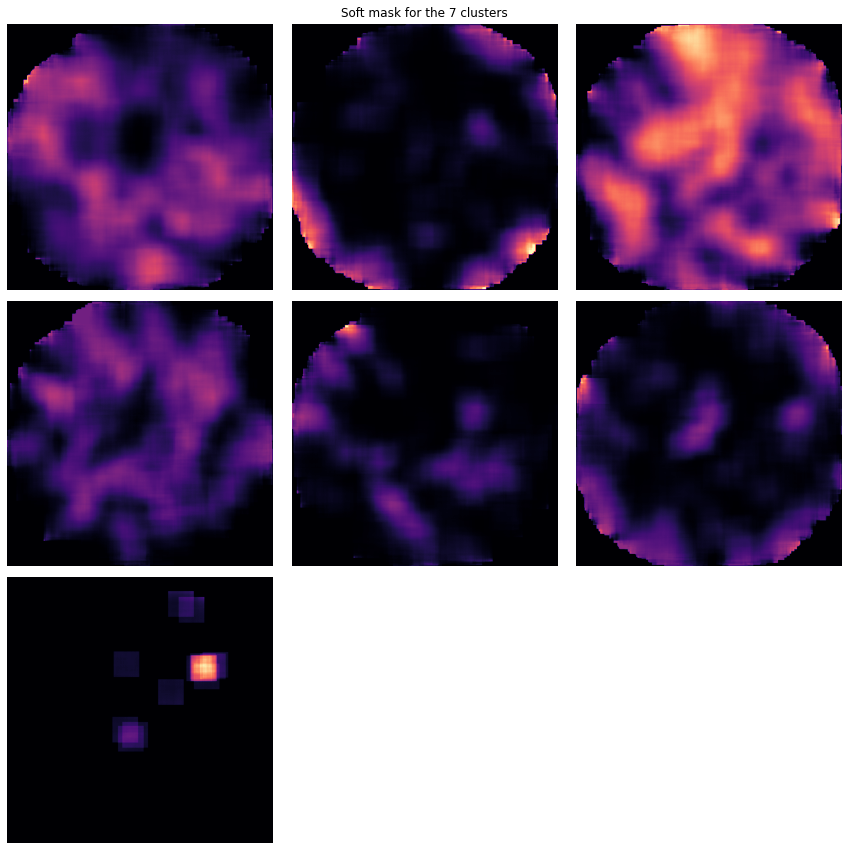

In [145]:
show_raw_one_channel(sp_images[0].image_properties['niche'], cmap="magma", n_col=3, title="Soft mask for the 7 clusters", scale_each=False, in_range=(0.0, 1.0))

In [159]:
for sp_img in sp_images:
    soft_usage = sp_img.image_properties['niche'].sum(dim=(-1,-2))
    sp_img.image_properties['soft_usage_fraction'] = soft_usage / soft_usage.sum()
    #print(soft_usage.shape)
    
    
    tmp = sp_img.image_properties['niche_argmax'] 
    hard_usage = torch.bincount(tmp[tmp>=0], minlength=soft_usage.shape[0])
    #print(hard_usage.shape)
    sp_img.image_properties['hard_usage_fraction'] = hard_usage / hard_usage.sum()

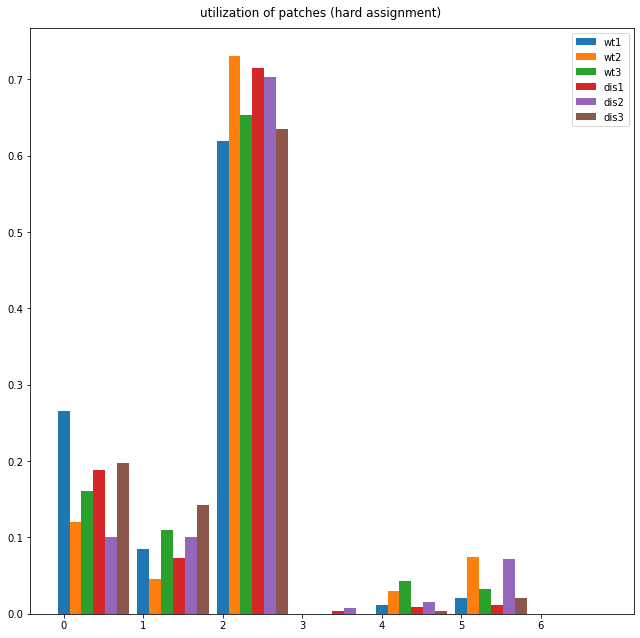

In [162]:
plot_counters([sp_img.image_properties['hard_usage_fraction'] for sp_img in sp_images], dataset_labels=list_f_names, title="utilization of patches (hard assignment)")

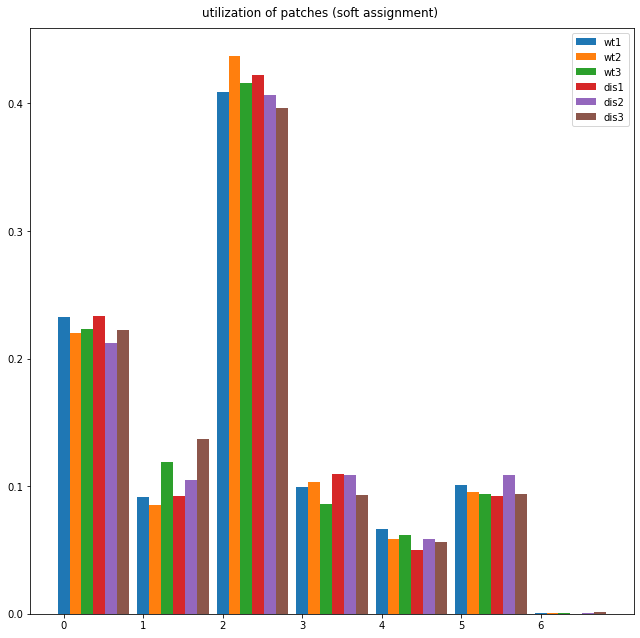

In [163]:
plot_counters([sp_img.image_properties['soft_usage_fraction'] for sp_img in sp_images], dataset_labels=list_f_names, title="utilization of patches (soft assignment)")

### Similar analysis for utilization of cell types

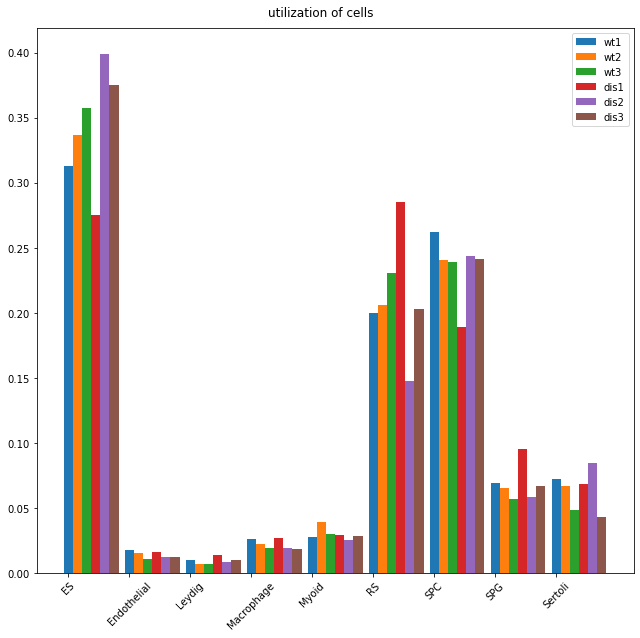

In [166]:
for sp_img in sp_images:
    cell_usage = channel_counter_in_window(sp_img)
    cell_usage_fraction = cell_usage / cell_usage.sum()
    sp_img.image_properties['cell_usage_fraction'] = cell_usage_fraction

plot_counters([sp_img.image_properties['cell_usage_fraction'] for sp_img in sp_images], dataset_labels=list_f_names, title="utilization of cells", x_labels=cell_names)   

In [ ]:
fig_cell_count = plot_channel_counts(
    counters=list_counters, 
    dataset_labels=list_f_names, 
    x_labels=cell_names,
    title="Cell counts in 6 slides",
    figsize=(9,9),
)
exp["cell_counts"].log(neptune.types.File.as_image(fig_cell_count))

In [ ]:
aa

In [31]:
import torchvision
from tissue_purifier.data_utils.transforms import *

cell_names = sp_images[0].code_to_cat.values()
dense_and_raster =torchvision.transforms.Compose([SparseToDense(), Rasterize(sigma=dm.rasterize_sigma)])
dense_img = dense_and_raster(sp_images[0].data)

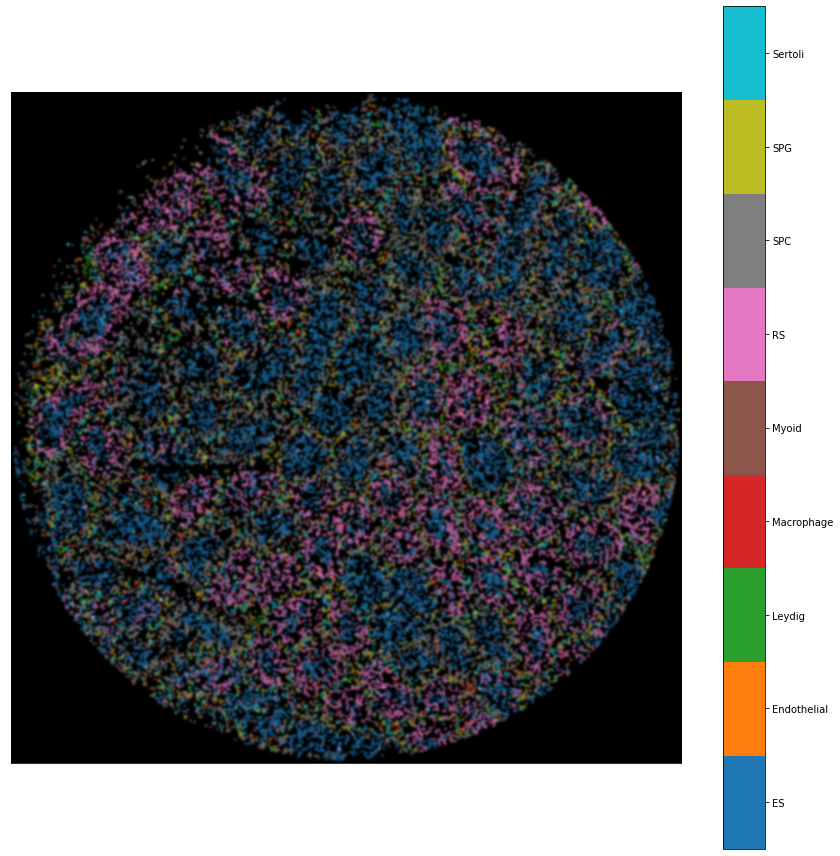

In [36]:
fig = show_raw_all_channels(dense_img, cmap="tab10", figsize=(12,12), labels=list(cell_names))
fig

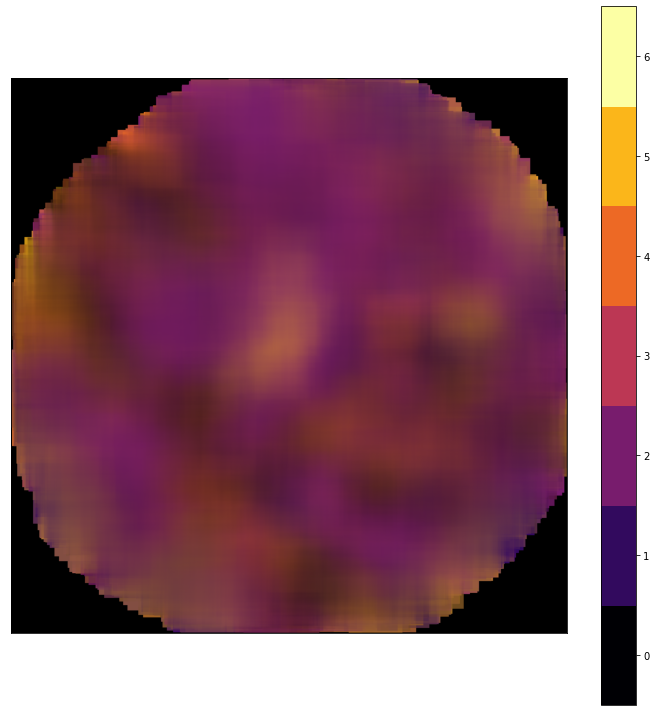

In [23]:
show_raw_all_channels(sp_images[0].image_properties['niche'], figsize=(10,10))

### Visualize Masks

In [ ]:
for sp_img in sp_images:
    prob_mask = sp_img.get_classifier_probs()
    
    sp_img.export_classification_to_original_data()
    

In [ ]:
config_dict_default_dm = SlideSeqTestisDM.get_default_params()

print(config_dict_default_dm)

config_dict_default_dm['data_dir'] = './'
config_dict_default_dm['pixel_size'] = 4.0
config_dict_default_dm['n_element_min_for_crop'] = 1000
config_dict_default_dm['rasterize_sigma'] = [1.0, 2.0]
config_dict_default_dm['n_crops_for_tissue_test'] = 1000
    
dm = SlideSeqTestisDM(**config_dict_default_dm)


# PASS UMAP + NEAREST NEIGHBOOR for doing classification.....

In [ ]:
from matplotlib.colors import ListedColormap

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "NearestN_1",
    "NearestN_5",
    "NearestN_15",
    "NearestN_50",
         #"RBF SVM", 
         #"Net", 
         #"Linear SVM", 
         #"Tree", 
         #"Forest", 
         #"AdaBoost",
         #"Naive Bayes", 
         #"QDA"
        ]

classifiers = [
    KNeighborsClassifier(1),
    KNeighborsClassifier(5),
    KNeighborsClassifier(15),
    KNeighborsClassifier(50),
    #SVC(C=1, decision_function_shape='ovr'),
    #MLPClassifier(alpha=1.0, max_iter=50000, hidden_layer_sizes=[10], tol=1E-5),
    #SVC(kernel="linear", C=0.001),
    # DecisionTreeClassifier(),
    #RandomForestClassifier(n_estimators=10, max_features=10),   
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
]


# Preparation for figure
n_col = 2
panel_size = 8

N_max = len(classifiers) + 1
n_row = int(numpy.ceil(float(N_max) / n_col))
figure = plt.figure(figsize=(panel_size*n_col, panel_size*n_row))

for i in range(N_max):
    ax = plt.subplot(n_row, n_col, i+1)
    
    if i == 0:
        ax.set_title("Input data")
        ax.scatter(xx, yy, s=1, c=y, cmap=plt.cm.tab10)    
    else:
        name, clf = names[i-1], classifiers[i-1]
        print(name)
        clf.fit(X_train, y_train)
        score_test = clf.score(X_test, y_test)
        score_train = clf.score(X_train, y_train)

        y_predicted = clf.predict(X)
        mask = (y_predicted == y)
        ax.set_title("{0} --> ({1:.3}, {2:.3})".format(name, score_train, score_test))
        ax.scatter(xx[mask], yy[mask], s=1, c=y_predicted[mask], cmap=plt.cm.tab10)
        ax.scatter(xx[~mask], yy[~mask], s=10, c=y_predicted[~mask], cmap=plt.cm.tab10)

In [ ]:
cm_test = confusion_matrix(y_test, y_test_predicted)
disp = ConfusionMatrixDisplay(cm_test)
disp.plot()
plt.show()

In [ ]:
adata.obs["predict"] = y_all_predicted
adata.obs["prediction_status"] = (y_all_predicted  == y_leiden).astype(int)
adata.obs["predict"] = adata.obs["predict"].astype('category')
adata.obs["prediction_status"] = adata.obs["prediction_status"].astype('category')
adata

In [ ]:
mask = numpy.array(adata.obs['prediction_status']).astype(bool)

plt.scatter(adata.obsm['X_umap'][mask,0], adata.obsm['X_umap'][mask,1], s=1, c=numpy.array(adata.obs['predict'][mask]).astype(int), cmap=plt.cm.tab10)
plt.scatter(adata.obsm['X_umap'][~mask,0], adata.obsm['X_umap'][~mask,1], s=20, c=numpy.array(adata.obs['predict'][~mask]).astype(int), cmap=plt.cm.tab10)

In [ ]:
mask = numpy.array(adata.obs['prediction_status']).astype(bool)

plt.scatter(adata.obsm['X_umap'][mask,0], adata.obsm['X_umap'][mask,1], s=1, c=numpy.array(adata.obs['leiden'][mask]).astype(int), cmap=plt.cm.tab10)
plt.scatter(adata.obsm['X_umap'][~mask,0], adata.obsm['X_umap'][~mask,1], s=20, c=numpy.array(adata.obs['leiden'][~mask]).astype(int), cmap=plt.cm.tab10)

# Make a spatialize

In [ ]:
from tissue_purifier.data_utils.datamodule import SlideSeqTestisDM
from tissue_purifier.model_utils.dino import DinoModel

config_dict_default_dm = SlideSeqTestisDM.get_default_params()
dm = SlideSeqTestisDM(**config_dict_default_dm)

config_dict_default_dino = DinoModel.get_default_params()
dino = DinoModel.load_from_checkpoint(checkpoint_path=ckpt_file)

In [ ]:
dm.prepare_data()

In [ ]:
dm.setup(stage=None)

In [ ]:
train_loader = dm.train_dataloader()
sparse_images = train_loader.dataset.imgs

In [ ]:
dm.cropper_reference

In [ ]:
classifier_mask = sparse_images[0].classify(
    model=dino,
    classifier=mlp_classifier,
    cropper_transform=dm,
    batch_size=64,
    n_patches_max=1000
    )



In [ ]:
from tissue_purifier.plot_utils.plot_data import show_raw_all_channels, show_raw_one_channel, plot_channel_counts

show_raw_one_channel(classifier_mask, cmap='gray', n_col=3)

In [ ]:
show_raw_all_channels(classifier_mask, cmap=plt.cm.tab10)

In [ ]:
plt.classifier_mask

### UMAP and CLUSTERING

# Logger

In [ ]:
env_vars = !cat ~/.bash_profile | grep NEPTUNE_API_TOKEN 
NEPTUNE_API_TOKEN = str(env_vars[0].split('\"')[1])

In [ ]:
import neptune.new as neptune
NEPTUNE_PROJECT = "cellarium/tissue-purifier"

exp: neptune.run.Run = neptune.init(project=NEPTUNE_PROJECT,
                                    api_token=NEPTUNE_API_TOKEN,
                                    mode="async",
                                    tags=["clustering"])

In [ ]:
partitions = [leidenalg.CPMVertexPartition, leidenalg.RBConfigurationVertexPartition]
normalizations = [True, False]
resolution_parameters = [0.1, 1.0, 10.0]

for p_type in partitions:
    for norm in normalizations:
        for r in resolution_parameters:
            graph = make_graph(umap_graph, normalized=norm)
            clusters = find_partition(graph, partition_type = p_type, resolution_parameter = r)

            clusters_fig = plot_embeddings(
                embeddings_umap,
                x_label="umap1",
                y_label="umap2",
                title=str(p_type)+"_"+str(norm)+"_"+str(r),
                labels=clusters,
                size=10,
                figsize=(10,10),
                cmap=plt.cm.tab10,
                legend=False,
            )
            exp["clusters"].log(neptune.types.File.as_image(clusters_fig))
        

In [ ]:
exp.stop()

## Compare anndata

In [ ]:
import scanpy as sc
import pandas as pd

tmp_dict = {
    "f_names" : f_names,
    "morans" : morans,
}

df = pd.DataFrame(tmp_dict)

adata = sc.AnnData(X=features, obs=df)
adata.obsm['X_raw'] = features

In [ ]:
adata

### Can I predict moran?

In [ ]:
x_all = bbone_embeddings
y_all = morans_all
stratify_by = fnames_all

x_train, x_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    stratify=stratify_by,
    test_size=0.2,
    random_state=1)

mlp_regression = MLPRegressor(
    hidden_layer_sizes=[],
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=100000,
    shuffle=True,
    random_state=1,
    tol=1E-6,
    verbose=False,
    n_iter_no_change=100,
    early_stopping=False)
mlp_regression.fit(x_train, y_train)

r2_test = mlp_regression.score(x_test, y_test)
r2_train = mlp_regression.score(x_train, y_train)

y_test_predicted = mlp_regression.predict(x_test)
y_train_predicted = mlp_regression.predict(x_train)


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))

axs[0].set_title("train dataset")
axs[0].scatter(y_train, y_train_predicted)
axs[0].set_ylabel("predicted")
axs[0].set_xlabel("actual")

axs[1].set_title("test dataset")
axs[1].scatter(y_test, y_test_predicted)
axs[1].set_ylabel("predicted")
axs[1].set_xlabel("actual")

axs[2].set_title("mlp loss")
axs[2].plot(mlp.loss_curve_)
axs[2].set_ylabel("regressor loss")
axs[2].set_xlabel("iteration")
axs[2].set_yscale("log")
print("We can predict moran with good_accuracy", r2_train, r2_test)

### Can I predict the tissue labels?

In [ ]:


x_all = bbone_embeddings
y_all = fnames_all
stratify_by = fnames_all

x_train, x_test, y_train, y_test = train_test_split(
    x_all,
    y_all,
    stratify=fnames_all,
    test_size=0.2,
    random_state=1)

mlp_classification = MLPClassifier(
    hidden_layer_sizes=[],
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=100000,
    shuffle=True,
    random_state=1,
    tol=1E-6,
    verbose=False,
    n_iter_no_change=100,
    early_stopping=False)

mlp_classification.fit(x_train, y_train)

mean_accuracy_test = mlp_classification.score(x_test, y_test)
mean_accuracy_train = mlp_classification.score(x_train, y_train)

y_test_predicted = mlp_classification.predict(x_test)
y_train_predicted = mlp_classification.predict(x_train)

cm_train = confusion_matrix(y_train, y_train_predicted, labels=mlp_classification.classes_)
cm_test = confusion_matrix(y_test, y_test_predicted, labels=mlp_classification.classes_)

cm_train_disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                       display_labels=mlp_classification.classes_)
cm_test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                      display_labels=mlp_classification.classes_)

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(24,8))

axs[0].set_title("train dataset")
cm_train_disp.plot(ax=axs[0])

axs[1].set_title("test dataset")
cm_test_disp.plot(ax=axs[1])

axs[2].set_title("mlp loss")
axs[2].plot(mlp_classification.loss_curve_)
axs[2].set_ylabel("regressor loss")
axs[2].set_xlabel("iteration")
axs[2].set_yscale("log")
print("We can predict tissue with excellent accuracy", mean_accuracy_train, mean_accuracy_test)

## Plot

In [ ]:
file_embeddings = "./output_prediction_random-413.pt"

output_prediction_tiling = torch.load(file_embeddings, map_location=torch.device('cpu'))
print("output_prediction_tiling.keys() -->", output_prediction_random.keys())

bbone_embeddings = output_prediction_tiling["features_bbone_ref_trsfm"]
head_embeddings = output_prediction_tiling["features_head_ref_trsfm"]

metadatas = output_prediction_tiling["metadata"]

morans_all = numpy.array([metadata.moran for metadata in metadatas])
fnames_all = numpy.array([metadata.f_name for metadata in metadatas])

## Plot BackBone embeddings

In [ ]:
bbone_embeddings_pca = get_pca(bbone_embeddings)

bbone_embeddings_umap, distances_bbone_nn = get_umap(
    bbone_embeddings, 
    n_neighbors=15, 
    metric='contrastive')

bbone_umap_fig1 = plot_embeddings(
    embeddings=bbone_embeddings_umap,
    size=20,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Backbone UMAP by tissue",
    colors=None,
    labels=fnames_all,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_umap_fig2 = plot_embeddings(
    embeddings=bbone_embeddings_umap,
    size=20,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Backbone UMAP by Moran score",
    colors=morans_all,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_pca_fig1 = plot_embeddings(
    embeddings=bbone_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Backbone PCA by tissue",
    colors=None,
    labels=fnames_all,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

bbone_pca_fig2 = plot_embeddings(
    embeddings=bbone_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Backbone PCA by Moran score",
    colors=morans_all,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

In [ ]:
bbone_umap_fig1.savefig("./random_umap_tissue.png")
bbone_umap_fig2.savefig("./random_umap_moran.png")

In [ ]:
paths = save_to_local_path([bbone_umap_fig1, bbone_umap_fig2, bbone_pca_fig1, bbone_pca_fig2])
ipyplot.plot_images(paths, max_images=5, img_width=400)

## Plot Head embeddings

In [ ]:
head_embeddings = output_prediction_random["features_head_ref_trsfm"]

head_embeddings_pca = get_pca(head_embeddings)

head_embeddings_umap, distances_head_nn = get_umap(
    bbone_embeddings, 
    n_neighbors=50, 
    metric='contrastive')

head_umap_fig1 = plot_embeddings(
    embeddings=head_embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Head UMAP by tissue",
    colors=None,
    labels=f_names,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_umap_fig2 = plot_embeddings(
    embeddings=head_embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="Head UMAP by Moran score",
    colors=moran,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_pca_fig1 = plot_embeddings(
    embeddings=head_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Head PCA by tissue",
    colors=None,
    labels=f_names,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

head_pca_fig2 = plot_embeddings(
    embeddings=head_embeddings_pca,
    x_label='PCA 1',
    y_label='PCA 2',
    title="Head PCA by Moran score",
    colors=moran,
    labels=None,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

In [ ]:
paths = save_to_local_path([head_umap_fig1, head_umap_fig2, head_pca_fig1, head_pca_fig2])
ipyplot.plot_images(paths, max_images=5, img_width=400)

# Unsupervised clustering of the Head embeddings

In [ ]:
distances_nn = distances_head_nn
embeddings_umap = head_embeddings_umap

graph_umap = make_graph(distances_nn=distances_head_nn,
                        n_neighbors=50,
                        metric='contrastive'
                       )

partition_umap = compute_partition(graph_umap, resolution_parameter=0.2)
 
cluster_plot = plot_embeddings(
    embeddings=embeddings_umap,
    x_label='UMAP 1',
    y_label='UMAP 2',
    title="UMAP",
    colors=None,
    labels=partition_umap.membership,
    figsize=(8,8),
    cmap=plt.cm.inferno
)

display(cluster_plot)

# FROM HERE. MAKE A CLASSIFIER WHICH PREDICTS THE CLUSTERS AND THEN WORK ON TILING. SWITCH IN NEW EMBEDDINGS

### Common import and set random seed

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import pytorch_lightning as pl
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200
torch.manual_seed(config['simulation']['RANDOM_SEED'])
np.random.seed(config['simulation']['RANDOM_SEED'])

### Read in all the csv file

In [ ]:
#data_folder = "/home/jupyter/data/slide-seq/original_data/"
data_folder = "../slide-seq-data"


df_wt1 = pd.read_csv(os.path.join(data_folder, "wt_1.csv"))
df_wt2 = pd.read_csv(os.path.join(data_folder, "wt_2.csv"))
df_wt3 = pd.read_csv(os.path.join(data_folder, "wt_3.csv"))
df_dis1 = pd.read_csv(os.path.join(data_folder, "sick_1.csv"))
df_dis2 = pd.read_csv(os.path.join(data_folder, "sick_2.csv"))
df_dis3 = pd.read_csv(os.path.join(data_folder, "sick_3.csv"))

## Cluster Embeddings

In [ ]:
from tissue_purifier.model_utils import TrainedEmbedding

model_folder = "../trained_model"
model = tp.model_utils.helpers.define_model(
    backbone_type=config["model_settings"]["BACKBONE_TYPE"],
    number_of_channels=config["model_settings"]["INPUT_CHANNELS"],
    num_of_filters=config["model_settings"]["BACKBONE_NUM_FTRS"],
    projection_out_dim=config["model_settings"]["PROJECTION_OUT_DIM"],
)
model.backbone.load_state_dict(torch.load(f"./model.pth")["resnet18_parameters"])
# model.load_state_dict(torch.load(f"{model_folder}/simclr_model_11.pt"))
model = model.cuda()
encoder = TrainedEmbedding(model)

In [ ]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


pca_aglomerative = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=15)), 
        ("cluster", AgglomerativeClustering(n_clusters=2))
    ]
)


In [ ]:
%%capture
mask_dis2 = tp.evaluation_utils.create_mask_for_sample(
    df_dis2, encoder, pca_aglomerative, config, proba=True, n_crops=1000
)

In [ ]:
df_dis2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis2, mask_dis2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis2["condition"] = df_dis2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)

In [ ]:
tp.plot_utils.disease_mask(df_dis2, "condition", figsize=(8, 4), title="DIS 2 Clustered Mask")

In [ ]:
%%capture
mask_wt2 = tp.evaluation_utils.create_mask_for_sample(df_wt2, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_wt2["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt2, mask_wt2, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt2["condition"] = df_wt2["nn_probas"].map(lambda x: 0 if x < 0.5 else 1)
tp.plot_utils.disease_mask(df_wt2, "condition", figsize=(8, 3), title="WT 2 Clustered Mask")

In [ ]:
%%capture
mask_dis1 = tp.evaluation_utils.create_mask_for_sample(df_dis1, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_dis1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_dis1, mask_dis1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_dis1["condition"] = df_dis1["nn_probas"].map(lambda x: 0 if x < 0.4 else 1)
tp.plot_utils.disease_mask(df_dis1, "condition", figsize=(8, 4), title="DIS 1 Clustered Mask")

In [ ]:
%%capture
mask_wt1 = tp.evaluation_utils.create_mask_for_sample(df_wt1, encoder, pca_aglomerative, config, proba=True, n_crops=1000)

In [ ]:
df_wt1["nn_probas"] = tp.evaluation_utils.spatialize_mask(df_wt1, mask_wt1, pixel_size=config["simulation"]["PIXEL_SIZE"])
df_wt1["condition"] = df_wt1["nn_probas"].map(lambda x: 0 if x < 0.4 else 1)
tp.plot_utils.disease_mask(df_wt1, "condition", figsize=(8, 4), title="WT 1 Clustered Mask")

## Moran's I Score Evaluation

In [ ]:
%%capture
moran_averaged = tp.evaluation_utils.moran_score_averaged(
    [df_wt1, df_wt2, df_dis1, df_dis2],
    ["WT1", "WT2", "DIS1", "DIS2"]
)

In [ ]:
moran_averaged.columns = ["total", "COND1", "COND2"]
moran_averaged